<a href="https://colab.research.google.com/github/Vovakul/Analytics/blob/main/%D0%A1%D0%B1%D0%B5%D1%80%D0%BC%D0%B0%D1%80%D0%BA%D0%B5%D1%82.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install psycopg2-binary

     |████████████████████████████████| 3.4 MB 5.4 MB/s 


In [333]:
import pandas as pd
import numpy as np

import psycopg2
from psycopg2 import Error

import seaborn as sns
import matplotlib.pyplot as plt

sns.set(rc={'figure.figsize':(12, 8)})

Задание 1. Представь, что ты главный аналитик в компании и собираешь дашборд с ключевыми метриками (от 4 до 6) для СЕО, на основании которых он будет судить о "здоровье" бизнеса, эффективности текущих операций и т.д. каждый день.
 Исходя из специфики индустрии и бизнес-модели СберМаркета, какие метрики ты бы отразил? Коротко можно объяснить почему.


**МЕТРИКИ**
1. Среднее кол-во заказов за предыдущий день (крупными цифрами и снизу процент отклонения от плана) и  линейный график с возможностью выбора периода и региона. Одна линия показывает кол-во заказов в день за прошедший период(так же показывается доверительный интервал), вторая линия показывает план по заказам - Это позволит посмотреть есть ли какие-то аномалии, если график будет выходить за границы дов. интервала или сильно отклоняется от плана. И так как компания растет быстро, то если произойдет резкое увеличение заказов, то сможем ли мы справиться с увеличиной нагрузкой на серверы и на доставку.
2. retention (по недельным когортам) с возможностью смотреть по городам - важно понимать сколько пользователей у нас остается после первого заказа. Одна из метрик которая может показать понравился ли пользователю продукт и какой процент будет постоянным 
3. Процент возвратов - то же можно считать показателем удовлетворенности продуктом. Качественный ли товар мы доставляем, либо можем предложить другой в замен товара, который отсутствует на полке. Вовремя ли наш каталог реагирует на отсутствие товара у партнера
4. Время доставки - среднее время доставки с разбивкой по службам доставки(пешие, авто, собственная доставка или партнеры)
5. Динамика роста новых пользователей. Так же с возможностью просмотра по городам
6. Время сессии в заказ - разбить время сессии по группам, например(до 1мин, 1-3мин, 3-5мин, 5-10мин, более 10мин) можно на barchart вывести какой процент пользователей пользуется продуктом в рамках наших временных групп и какой процент из них сконвертировался в заказ. Это поможет понять сколько необходимо удерживать внимание пользователя для лучшей конверсии и в каких зонах конверсия низкая.
7. Процент брошенных корзин на рахных этапах (выбор времени доставки, выбор способа платежа, регистрация и др.)


In [3]:
conn = psycopg2.connect (host='rc1c-fhrb9f1e0l9g611h.mdb.yandexcloud.net',
port=6432,
dbname='hr-analytics',
sslmode='require',
user='analytics',
password='HRanalytics'
)

In [4]:
cur=conn.cursor()

In [5]:
def create_pandas_table(sql_query, database = conn):
    table = pd.read_sql_query(sql_query, database)
    return table

In [6]:
orders_len = create_pandas_table("""SELECT 
                                   COUNT(id)
                                FROM orders
                              """)

In [7]:
orders_len  # проверяем количество строк в датасете, чтобы понять можно ли его весь загрузить в notebook 

,count
0,720433


In [8]:
orders = create_pandas_table("""SELECT *
                                FROM orders
                              """)

In [9]:
orders.info()  

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 720433 entries, 0 to 720432
Data columns (total 14 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   id                  720433 non-null  int64         
 1   user_id             720433 non-null  int64         
 2   total_cost          720433 non-null  float64       
 3   cost                720433 non-null  float64       
 4   item_total          720433 non-null  int64         
 5   promo_total         720433 non-null  float64       
 6   total_weight        720433 non-null  int64         
 7   total_quantity      720433 non-null  int64         
 8   state               720433 non-null  object        
 9   shipped_at          720433 non-null  datetime64[ns]
 10  created_at          720433 non-null  datetime64[ns]
 11  ship_address_id     720433 non-null  int64         
 12  store_id            720433 non-null  int64         
 13  delivery_window_id  720433 no

In [10]:
orders.created_at.min()

Timestamp('2018-08-26 00:05:41')

In [11]:
last_date = orders.created_at.max()

In [12]:
orders.shipped_at.max()

Timestamp('2019-12-18 23:47:42')

In [13]:
orders.head(10)


,id,user_id,total_cost,cost,item_total,promo_total,total_weight,total_quantity,state,shipped_at,created_at,ship_address_id,store_id,delivery_window_id
0,756927,139676,0.0,0.0,5015,0.0,37708,39,shipped,2018-08-26 15:01:42,2018-08-26 02:06:55,888330,1,226459
1,756963,139682,0.0,0.0,7096,0.0,49435,71,shipped,2018-08-26 16:28:41,2018-08-26 05:43:20,888394,1,226460
2,756983,63967,299.0,299.0,2724,-250.0,11590,32,shipped,2018-08-26 15:09:11,2018-08-26 06:12:13,888420,1,226459
3,756985,139687,0.0,0.0,3471,0.0,9915,13,shipped,2018-08-26 18:57:01,2018-08-26 06:13:59,888422,1,226462
4,757066,119006,299.0,299.0,1254,0.0,15022,24,shipped,2018-08-26 13:46:48,2018-08-26 07:40:58,870688,1,226458
5,757094,36196,0.0,0.0,2193,0.0,2259,5,shipped,2018-08-27 16:19:06,2018-08-26 08:01:04,865563,1,227250
6,757117,125115,249.0,249.0,2985,-350.0,21930,24,shipped,2018-08-27 13:56:22,2018-08-26 08:14:10,778649,1,227237
7,757132,24836,299.0,299.0,2540,0.0,1120,2,shipped,2018-08-27 14:02:10,2018-08-26 08:19:43,828165,1,227245
8,757134,99699,299.0,299.0,597,-450.0,15165,17,shipped,2018-08-26 20:18:37,2018-08-26 08:21:14,888655,1,226464
9,757142,139718,0.0,0.0,3309,0.0,52200,49,shipped,2018-08-26 17:21:58,2018-08-26 08:23:56,888668,1,226461


In [14]:
orders.promo_total.sum()

-37055018.290000014

In [15]:
orders.cost.sum() - orders.total_cost.sum()

58094895.999999985

In [16]:
users_uniq = orders.user_id.nunique()
users_uniq

257827

In [17]:
orders_state = orders.groupby('state', as_index=False).agg({'total_cost': 'sum', 'id': 'count', 'total_weight': 'sum' })

In [18]:
orders_state['total_cost'] = orders_state.total_cost.round(0)

In [19]:
orders_state

,state,total_cost,id,total_weight
0,canceled,3050.0,15,475124
1,pending,3460.0,12,411063
2,ready,0.0,1,22000
3,shipped,123778431.0,720404,17712163157
4,shipping,258.0,1,54096


In [20]:
orders.query("state == 'canceled'")

,id,user_id,total_cost,cost,item_total,promo_total,total_weight,total_quantity,state,shipped_at,created_at,ship_address_id,store_id,delivery_window_id
119159,2917814,1129004,299.0,299.0,725,0.0,11655,25,canceled,2019-10-25 11:14:15,2019-10-21 15:39:32,4193170,3,808418
130068,765089,123890,199.0,199.0,15935,0.0,22650,21,canceled,2018-08-30 12:53:16,2018-08-30 08:54:24,868201,8,230002
193825,4264275,961184,299.0,299.0,6172,0.0,24206,49,canceled,2019-11-20 11:51:41,2019-11-19 17:42:08,4941212,9,875426
266477,3408961,1232248,299.0,299.0,3613,0.0,23870,40,canceled,2019-11-06 14:51:55,2019-11-03 18:54:01,4757922,11,839017
324253,820764,156619,0.0,0.0,851,0.0,240,6,canceled,2018-09-28 15:12:57,2018-09-28 15:08:01,1002269,14,254206
327847,924962,186248,0.0,299.0,2474,0.0,2200,3,canceled,2018-11-16 11:43:38,2018-11-16 11:31:48,1181945,14,303088
368836,4233456,773943,566.0,566.0,13908,0.0,142180,126,canceled,2019-11-25 07:55:17,2019-11-19 04:38:56,5521222,14,888803
369062,4262575,1087110,359.0,359.0,8870,0.0,41507,69,canceled,2019-11-20 13:38:16,2019-11-19 16:58:25,5639697,14,875630
380031,1018002,123143,149.0,149.0,6906,0.0,20000,20,canceled,2018-12-28 15:34:58,2018-12-28 15:34:47,1332920,18,348384
380032,1018024,123143,149.0,149.0,6993,0.0,20000,20,canceled,2018-12-28 15:41:13,2018-12-28 15:40:59,1332945,18,348383


In [21]:
# таблица, с разбивкой по месяцам, данных заказов, суммой достовки до и % скидки от изначальной стоимости доставки.   
orders_month = create_pandas_table("""
                    SELECT
                        a.orders_by_month,
                        first_value(a.orders_by_month) OVER w ,
                        a.total_cost,
                        a.avg_total_cost,
                        a.cost,
                        a.avg_cost,
                        a.diff_per_cost,
                        a.created_at_month
                        FROM
                          (SELECT
                            COUNT(id) as orders_by_month,
                            SUM(total_cost) as total_cost,
                            round(CAST(AVG(total_cost) as numeric), 2) as avg_total_cost,
                            SUM(cost) as cost,
                            round(CAST(AVG(cost) as numeric), 2) as avg_cost,
                            round(CAST((1 - SUM(total_cost) / SUM(cost)) * 100 as numeric), 2) as diff_per_cost,
                            date_trunc('month', created_at) as created_at_month
                          FROM
                            orders
                          WHERE state != 'canceled'
                          GROUP BY 
                            created_at_month) AS a
                        WINDOW w AS (ROWS BETWEEN 1 PRECEDING AND 1 FOLLOWING)
                            """)

In [22]:
orders_month.head()

,orders_by_month,first_value,total_cost,avg_total_cost,cost,avg_cost,diff_per_cost,created_at_month
0,3235,3235,681354.00,210.62,713213.00,220.47,4.47,2018-08-01
1,16710,3235,3259058.67,195.04,3571681.67,213.75,8.75,2018-09-01
2,19426,16710,3815910.73,196.43,4787901.73,246.47,20.30,2018-10-01
3,19809,19426,3814424.80,192.56,6553622.80,330.84,41.80,2018-11-01
4,17285,19809,3244839.98,187.73,5198574.98,300.76,37.58,2018-12-01


In [23]:
orders_month['orders_dynamic'] = round((1 - orders_month.first_value / orders_month.orders_by_month) * 100, 2)  # добавляю столбец с процентным изменением заказов к предыдущему месяцу
orders_month = orders_month.drop(columns=['first_value']).reindex(columns=['created_at_month', 'orders_by_month', 'orders_dynamic', 'total_cost', 'avg_total_cost', 'cost', 'avg_cost', 'diff_per_cost'])

In [24]:
orders_month.head()

,created_at_month,orders_by_month,orders_dynamic,total_cost,avg_total_cost,cost,avg_cost,diff_per_cost
0,2018-08-01,3235,0.00,681354.00,210.62,713213.00,220.47,4.47
1,2018-09-01,16710,80.64,3259058.67,195.04,3571681.67,213.75,8.75
2,2018-10-01,19426,13.98,3815910.73,196.43,4787901.73,246.47,20.30
3,2018-11-01,19809,1.93,3814424.80,192.56,6553622.80,330.84,41.80
4,2018-12-01,17285,-14.60,3244839.98,187.73,5198574.98,300.76,37.58


In [25]:
orders_month.corr()

,orders_by_month,orders_dynamic,total_cost,avg_total_cost,cost,avg_cost,diff_per_cost
orders_by_month,1.000000,0.038359,0.986693,-0.269688,0.998473,-0.167302,0.145387
orders_dynamic,0.038359,1.000000,0.030934,-0.071521,0.010553,-0.411699,-0.238058
total_cost,0.986693,0.030934,1.000000,-0.124751,0.988020,-0.134017,0.047905
avg_total_cost,-0.269688,-0.071521,-0.124751,1.000000,-0.256844,0.121207,-0.759885
cost,0.998473,0.010553,0.988020,-0.256844,1.000000,-0.115779,0.167941
avg_cost,-0.167302,-0.411699,-0.134017,0.121207,-0.115779,1.000000,0.546200
diff_per_cost,0.145387,-0.238058,0.047905,-0.759885,0.167941,0.546200,1.000000


Из этой таблицы хотелось посмотреть есть ли корреляция между объемом выданых скидок на достаку и количеством заказов. Взамосвязи между этими событиями не выявлено. Пока не ясно есть ли смысл проводить масштабные скидочные акции.
Возможно стоит снизить объем выдаваемых скидок на доставку. И делать это более персонализировано.

In [26]:
  orders_month_by_cities = create_pandas_table("""
                          SELECT
                            date_trunc('month', created_at) as created_at_month,
                            r.city as city,                            
                            l.store_id as store_id,                         
                            l.id as id,
                            l.total_cost as total_cost,
                            l.cost as cost
                          FROM
                            orders as l
                          JOIN stores as r
                            ON l.store_id = r.id
                          WHERE state != 'canceled'
                            """)

In [27]:
orders_month_group = (orders_month_by_cities.groupby(['created_at_month', 'city'], as_index=False)
    .agg({'id': 'count', 'cost': 'mean', 'total_cost': 'mean'})
    .rename(columns={'id': 'orders'}))

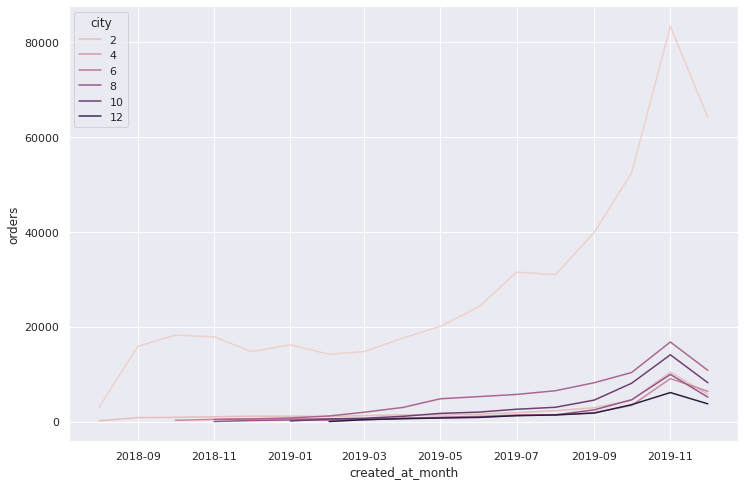

In [28]:
# График заказов по месяцам в разрезе городов
sns.lineplot(data=orders_month_group, x="created_at_month", y="orders", hue="city")

In [29]:
print(f'количество выполненых заказов в городе 1 составляет {orders_month_group.query("city == 1").orders.sum()}, за весь период')

количество выполненых заказов в городе 1 составляет 478849, за весь период


Каких-то аномалий по динамике заказов в разбивке по городам, визуально, не наблюдается. За исключением падения количества заказов в гроде "1" в декабре 2018 года. Так же есть падение в феврале 2019г. Но я пологаю, что для февраля такое снижение может объяснится сезонностью

RFM анализ. Разобьем клиентов на классы и посмотрим в каком классе у нас больше всего клиентов и какой доход они нам приносят.

In [30]:
rfm_table = orders.groupby('user_id', as_index=False).agg({'created_at': lambda x: (last_date - x.max()).days,
                               'id': lambda x: len(x),
                               'total_cost': lambda x: x.sum()})


In [31]:
rfm_table.rename(columns={'created_at': 'recency',
                          'id': 'frequency',
                          'total_cost': 'monetary_value'}, inplace=True)

In [32]:
rfm_table

,user_id,recency,frequency,monetary_value
0,31,8,41,10150.0
1,45,6,31,7386.0
2,63,452,1,249.0
3,167,329,37,9566.0
4,176,273,1,0.0
...,...,...,...,...
257822,1837005,0,1,98.0
257823,1837043,0,1,98.0
257824,1837423,0,1,98.0
257825,1837462,0,1,98.0


In [33]:
quantiles = rfm_table.quantile(q=[0.25,0.5,0.75])  # определяю границы классов
quantiles

,user_id,recency,frequency,monetary_value
0.25,265205.5,14.0,1.0,49.0
0.50,791629.0,48.0,1.0,164.0
0.75,1365612.5,156.0,3.0,455.0


In [34]:
def RClass (value, parameter_name, quantiles_table):
    if value <= quantiles_table[parameter_name][0.25]:
        return 1
    elif value <= quantiles_table[parameter_name][0.50]:
        return 2
    elif value <= quantiles_table[parameter_name][0.75]:
        return 3
    else:
        return 4

def FMClass (value, parameter_name, quantiles_table):
    if value <= quantiles_table[parameter_name][0.25]:
        return 4
    elif value <= quantiles_table[parameter_name][0.50]:
        return 3
    elif value <= quantiles_table[parameter_name][0.75]:
        return 2
    else:
        return 1

In [35]:
rfm_segmentation = rfm_table

In [36]:
rfm_segmentation['R_class'] = rfm_segmentation['recency'].apply(RClass, args=('recency', quantiles))
rfm_segmentation['F_class'] = rfm_segmentation['frequency'].apply(FMClass, args=('frequency', quantiles))
rfm_segmentation['M_class'] = rfm_segmentation['monetary_value'].apply(FMClass, args=('monetary_value', quantiles))

rfm_segmentation['RFM_class'] = rfm_segmentation['R_class'].map(str) \
                              + rfm_segmentation['F_class'].map(str) \
                              + rfm_segmentation['M_class'].map(str)

In [37]:
rfm_segmentation

,user_id,recency,frequency,monetary_value,R_class,F_class,M_class,RFM_class
0,31,8,41,10150.0,1,1,1,111
1,45,6,31,7386.0,1,1,1,111
2,63,452,1,249.0,4,4,2,442
3,167,329,37,9566.0,4,1,1,411
4,176,273,1,0.0,4,4,4,444
...,...,...,...,...,...,...,...,...
257822,1837005,0,1,98.0,1,4,3,143
257823,1837043,0,1,98.0,1,4,3,143
257824,1837423,0,1,98.0,1,4,3,143
257825,1837462,0,1,98.0,1,4,3,143


In [38]:
RFM_vizualziation = rfm_segmentation.pivot_table(
                    index='R_class',
                    columns='F_class',
                    values='monetary_value',
                    aggfunc=np.median).applymap(int)

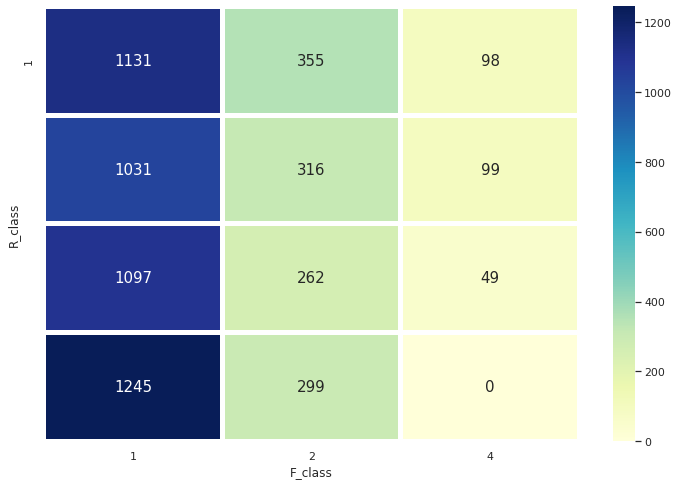

In [39]:
sns.heatmap(RFM_vizualziation, cmap="YlGnBu", annot=True, fmt=".0f", linewidths=4.15, annot_kws={"size": 15}, yticklabels=4)

Из этой таблицы можно определить самых лояльных наших клиентов и с каких групп клиентов мы больше всего зарабатываем. А так же видно не лояльных клиентов и которые по какой-то давно не совершали заказы

In [40]:
rfm_segmentation_distribution = rfm_segmentation.groupby('RFM_class', as_index=False).agg({'user_id': 'count'}).sort_values('user_id', ascending=False).rename(columns={'user_id': 'user_id_quantity'})

In [41]:
# Смотрю  к какому классу какой % пользователей относится
rfm_segmentation_distribution['distrib_per'] = round((rfm_segmentation_distribution.user_id_quantity / users_uniq) * 100, 2)  

In [42]:
rfm_segmentation_distribution

,RFM_class,user_id_quantity,distrib_per
47,444,37447,14.52
0,111,20852,8.09
35,344,20414,7.92
22,243,18536,7.19
10,143,15540,6.03
34,343,14235,5.52
21,242,12702,4.93
5,122,11939,4.63
17,222,10570,4.10
24,311,10167,3.94


Более 25% пользователей у нас принадлежит к худьшим классам. К самому лучшему и лояльному классу у нас относится более 8%.
Это говорит о том, что большая доля пользователей не остаются в продукте и не пользуются. Хорошо было бы посмотреть на то какие признаки могут связывать таких пользователей. Посмотреть как они пользовались продуктом и сформировать гипотезы почему они могли уйти из продукта и как устранить возможные проблемы.    

Далее хочу посмотреть какова конверсия во вторую покупку. Это поможет нам понять какая доля пользователей хотят повторно воспользоваться продуктом

In [365]:
second_orders = orders.groupby('user_id', as_index=False).agg({'id': 'count'}).sort_values('id', ascending=False).query("id > 1")  # таблица с пользовыателями которые сделали более одного заказа

In [366]:
print(f'{second_orders.shape[0]} пользователей совершивших более 1-ой покупки')

113168 пользователей совершивших более 1-ой покупки


In [367]:
print(f'конверсия во вторую покупку у {round(second_orders.shape[0] / users_uniq *100, 2)}% пользователей')

конверсия во вторую покупку у 43.89% пользователей


In [368]:
first_order = (orders[['user_id', 'created_at', 'id', 'state']]
               .query("state != 'canceled'")
               .sort_values('created_at')
               .drop_duplicates(subset=['user_id'])
               .drop(columns={'state'})
               .rename(columns={'created_at': 'created_at_first'}))
first_order

,user_id,created_at_first,id
274801,81165,2018-08-26 00:05:41,756914
380700,4225,2018-08-26 00:07:14,756916
0,139676,2018-08-26 02:06:55,756927
129874,139671,2018-08-26 03:36:34,756933
97068,139672,2018-08-26 03:46:09,756934
...,...,...,...
175471,1252292,2019-12-18 17:20:21,5443348
175472,1837462,2019-12-18 17:26:10,5443574
379980,1284905,2019-12-18 17:32:10,5443796
239665,1266916,2019-12-18 17:59:16,5444744


In [369]:
second_orders = orders[['user_id', 'created_at', 'id', 'state']].query("state != 'canceled'").drop(columns={'state'})
second_orders

,user_id,created_at,id
0,139676,2018-08-26 02:06:55,756927
1,139682,2018-08-26 05:43:20,756963
2,63967,2018-08-26 06:12:13,756983
3,139687,2018-08-26 06:13:59,756985
4,119006,2018-08-26 07:40:58,757066
...,...,...,...
720428,1676786,2019-12-18 09:16:28,5423310
720429,1832586,2019-12-18 09:20:18,5423488
720430,1318477,2019-12-18 09:41:28,5424466
720431,1116106,2019-12-18 10:18:37,5426016


In [379]:
date_format = 'M'  # выберите период когорты где 'Y'-год, 'M'-месяц, 'W'-неделя, 'D'-день

period = "'2018' <= created_at_first <= '2020'"  # Выберите период, за который хотите посмотреть retention
                                       # прим.("'2018-01-01' <= reg_ts <= '2019-01-01'")

In [371]:
def retention_rate_percent(first_order, second_orders):
    # изменяем даты на период определенной когорты
    first_order['created_at_first'] = first_order['created_at_first'].dt.to_period(date_format).apply(lambda r: r.start_time) 
    second_orders['created_at'] = second_orders['created_at'].dt.to_period(date_format).apply(lambda r: r.start_time)

    df_merge = second_orders.merge(first_order, how='left', on='user_id')  # объединяю таблицу событий с датой регистрации по когортам

    # добавляем порядковый номер выбраному периоду 
    df_merge['lifetime'] = ((df_merge['created_at'] - df_merge['created_at_first'])/np.timedelta64(1, date_format)).round().astype(int)

    # Строим таблицу retention по количеству пользователей
    retention = df_merge.query(period).pivot_table(index='created_at_first', columns='lifetime', values='user_id', aggfunc='nunique')

    # Строим таблицу retention по проценту пользователей
    retention_percent = retention.apply(lambda row: (row.iloc[0::]/row.iloc[0])*100, axis=1).round(0)
    
    return retention_percent   

In [372]:
# смотрю на retention % на графике
def heatmap(retention_rate_percent):
    plt.figure(figsize=(24, 12))
    plt.title('Retention %' , fontsize=24)
    plt.ylabel('cohorts', fontsize=18)
    plt.xlabel('number', fontsize=18)
    ax = sns.heatmap(retention_rate_percent, linewidth=1, annot=True, fmt='.0f', cmap='BuPu', linecolor='black', annot_kws={"size":15})
    plt.show()
                

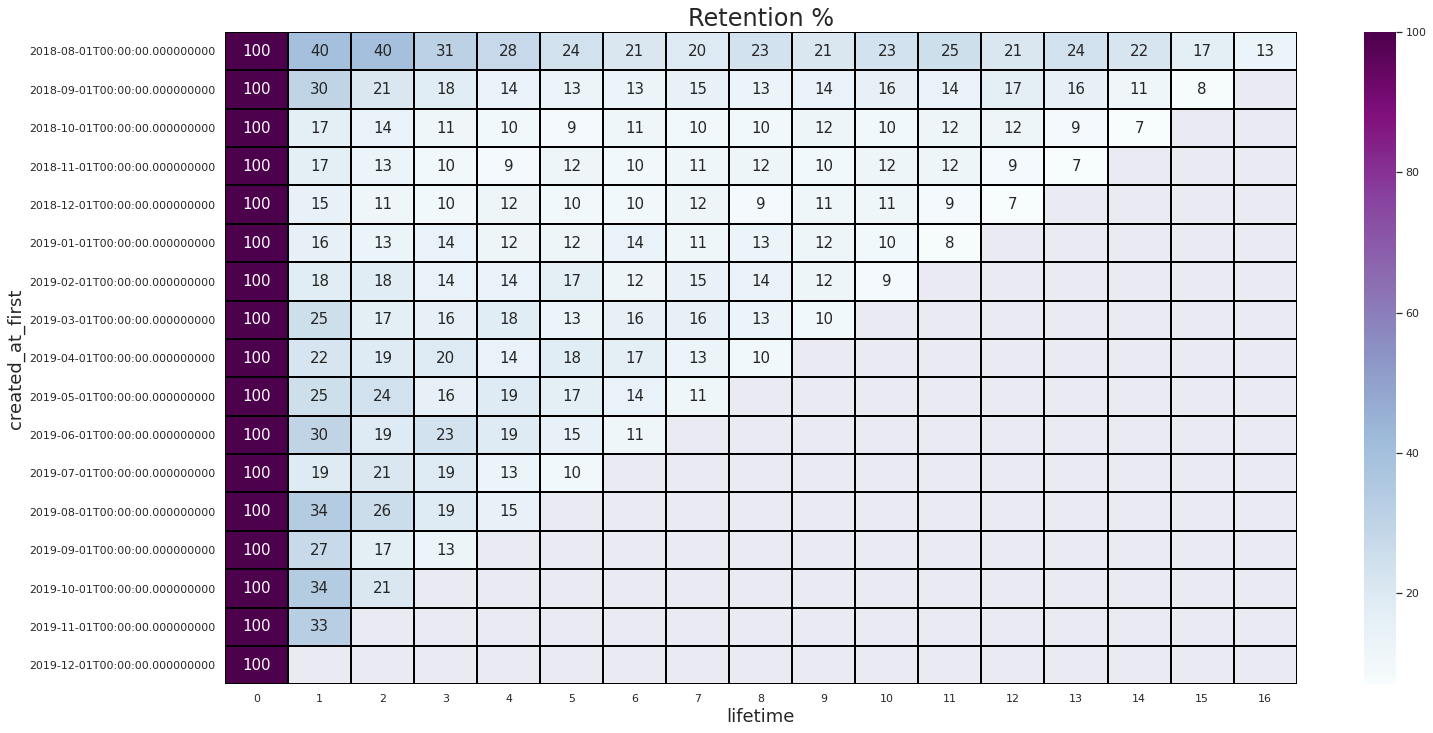

In [380]:
heatmap(retention_rate_percent(first_order, second_orders))

In [374]:
date_format = 'W'  # выберите период когорты где 'Y'-год, 'M'-месяц, 'W'-неделя, 'D'-день

period = "'2019-01-01' <= created_at_first <= '2020'"  # Выберите период, за который хотите посмотреть retention
                                       # прим.("'2018-01-01' <= reg_ts <= '2019-01-01'")

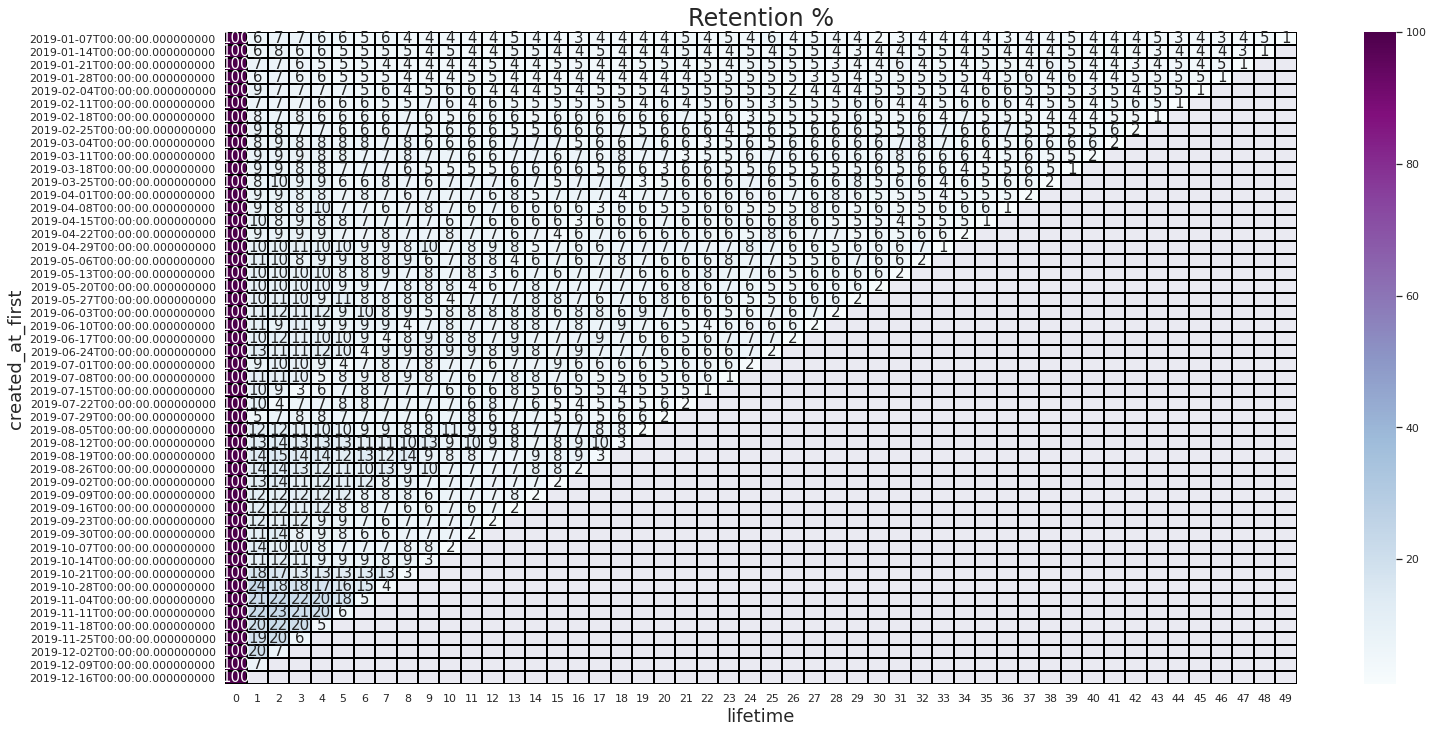

In [375]:
heatmap(retention_rate_percent(first_order, second_orders))

Посчитав retention по когортам, в разрезе месяца и недели, видно что в 2018г пользователи реже возвращались в продукт чем в 2019г.
 Однако стоит заметить, что в июле 2019г был очень низкий retention на первой недели. Данный отрезок времени стоит проанализировать дополнительно на (сбои в приложениии, или каких-либо обновлений)
 В целом можно заметить, что от 7-10% пользователей остается с нами на длительное время после первой покупки. Даже учитывая то, что аудитория увеличивалась в разы.
 1. Масштабировать бизнес и увеличивать количество клиентов нужно. Мы будем понимать, что 7-10% из них остнется
 2. Проработать гипотезы, как мы можем увеличить retention первой недели или первого месяца, какие комуникации мы можем провести с пользователями для того чтобы они возвращались к нам после первого заказа.
 